# Summary of filters

Families:
* Remove 11299, outlier with 893 total denovos

In [34]:
%pylab inline

import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['table', 'f', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [35]:
# Load data (by child/family)
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/" # TODO use filtered
#PERIOD=2
#bychild = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_bychild2_period%s.tab"%PERIOD), sep="\t")
bychild = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_bychild2.tab"), sep="\t")

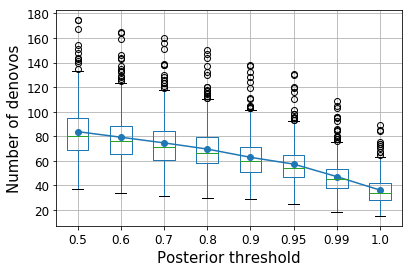

In [36]:
# For unaffecteds, get total de novos by threshold
fig = plt.figure()
ax = fig.add_subplot(111)
bp = bychild[(bychild["status"]==1) & (bychild["pthresh"]!=0)].boxplot(by="pthresh", column="numutations", ax=ax,
                                                                 return_type="dict")
ax.set_title("");
fig.suptitle("")
ax.set_xlabel("");
ax.set_ylabel("Number of denovos", size=15)
ax.set_xlabel("Posterior threshold", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);

# Plot means
bychild_means = bychild[(bychild["status"]==1) & (bychild["pthresh"]!=0)].groupby("pthresh", as_index=False).agg({"numutations": np.mean})
ax.plot(ax.get_xticks(), bychild_means["numutations"], marker="o");

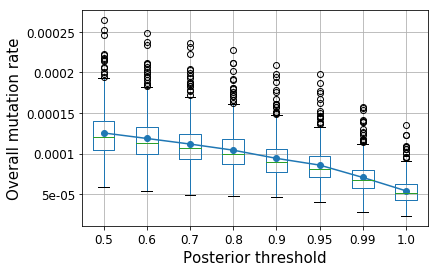

In [37]:
# For unaffecteds, get rate by threshold

bychild_totals = bychild[(bychild["pthresh"]==0)].groupby(["family","child","status"], as_index=False).agg({"numutations": np.max})
bychild_totals["total"] = bychild_totals["numutations"]
bychild_rates = pd.merge(bychild, bychild_totals[["family","child","status","total"]], on=["family","child","status"])
bychild_rates["rate"] = bychild_rates.apply(lambda x: x["numutations"]*1.0/x["total"], 1)
bychild_rates = bychild_rates[~((bychild_rates["pthresh"]==0) & (bychild_rates["rate"]<1))] # TODO remove after fix

fig = plt.figure()
ax = fig.add_subplot(111)
bp = bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"]!=0)].boxplot(by="pthresh", column="rate", ax=ax,
                                                                 return_type="dict")
ax.set_title("");
fig.suptitle("")
ax.set_xlabel("");
ax.set_ylabel("Overall mutation rate", size=15)
ax.set_xlabel("Posterior threshold", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

# Plot means
bychild_means = bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"]!=0)].groupby("pthresh", as_index=False).agg({"rate": np.mean})
ax.plot(ax.get_xticks(), bychild_means["rate"], marker="o");

numutations	(0.37241579914597572, 4.4931026312787304e-17)
rate	(0.31946414848689197, 9.8957572797285326e-13)


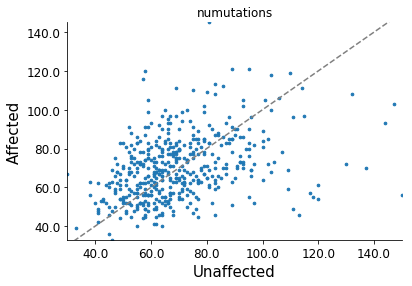

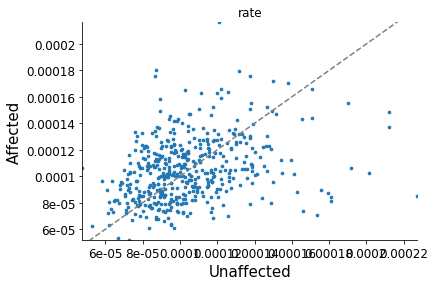

In [50]:
# Plot by child for each family
pthresh = 0.8
buf = 10
unaffected = bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"] == pthresh)]
affected = bychild_rates[(bychild_rates["status"]==2) & (bychild_rates["pthresh"] == pthresh)]
sibs = pd.merge(unaffected, affected, on=["family"])

for col in ["numutations","rate"]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(sibs["%s_x"%col], sibs["%s_y"%col], s=7)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_xlabel("Unaffected", size=15)
    ax.set_ylabel("Affected", size=15)
    minval = min(list(unaffected[col])+list(affected[col]))
    maxval = max(list(unaffected[col])+list(affected[col]))
    ax.plot([minval, maxval],[minval,maxval], color="gray", linestyle="dashed")
    ax.set_xlim(left=min(unaffected[col]), right=max(unaffected[col]))
    ax.set_ylim(bottom=min(affected[col]), top=max(affected[col]))
    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.set_yticklabels(ax.get_yticks(), size=12);
    ax.set_title(col)
    print(col + "\t" + str(scipy.stats.pearsonr(sibs["%s_x"%col], sibs["%s_y"%col])))

Ttest_1sampResult(statistic=0.61909736318735487, pvalue=0.53614964914464447)
Ks_2sampResult(statistic=0.075789473684210518, pvalue=0.12484020014758775)


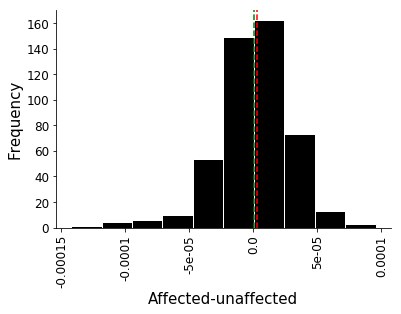

In [51]:
# Histogram of diff in affected-unaffected
fig = plt.figure()
ax = fig.add_subplot(111)
u = sibs[sibs["family"] != 11299]["rate_x"]
a = sibs[sibs["family"] != 11299]["rate_y"]
diff = a-u
ax.hist(diff,
        color="black", edgecolor="white");
ax.set_xlabel("Affected-unaffected", size=15);
ax.set_ylabel("Frequency", size=15);
ax.set_xticklabels(map(lambda x: (x), ax.get_xticks()), size=12, rotation=90);
ax.set_yticklabels(map(lambda x: int(x), ax.get_yticks()), size=12);
ax.axvline(np.median(diff), color="red", linestyle="dashed")
ax.axvline(np.mean(diff), color="green", linestyle="dashed")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print(str(scipy.stats.ttest_1samp(diff, popmean=0)))
print(str(scipy.stats.ks_2samp(u, a)))

EUR vs. AFR	Ks_2sampResult(statistic=0.36158715454685808, pvalue=0.020677975915082372)
EUR vs. ASIA	Ks_2sampResult(statistic=0.19362920544022899, pvalue=0.37776376114650728)
AFR vs. ASIA	Ks_2sampResult(statistic=0.50534759358288761, pvalue=0.0090123864037448473)
EUR vs. AFR	Ttest_indResult(statistic=-2.3006111233388449, pvalue=0.021932579882366535)
EUR vs. ASIA	Ttest_indResult(statistic=0.65789512186668853, pvalue=0.51098301264280921)
AFR vs. ASIA	Ttest_indResult(statistic=2.148725837085272, pvalue=0.038268155910445897)


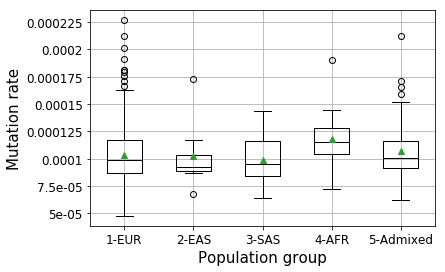

In [52]:
# Plot by population
pthresh = 0.8
sscpop = pd.read_csv("../../metadata/ssc_family_populations.tab", sep="\t")
sscpop = pd.merge(sscpop, bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"]==pthresh)],
                  on=["family"])
fig = plt.figure()
ax = fig.add_subplot(111)
boxprops = dict(linestyle='-', linewidth=1)
medianprops = dict(linestyle='-', linewidth=1)

poplabels = {
    "EUR": "1-EUR",
    "EAS": "2-EAS",
    "SAS": "3-SAS",
    "AFR": "4-AFR",
    "Admixed": "5-Admixed"
}
sscpop["SuperpopLabel"] = sscpop["Superpop"].apply(lambda x: poplabels[x])
bp = sscpop.boxplot(by="SuperpopLabel", column="rate", ax=ax, boxprops=boxprops,
                medianprops=medianprops, return_type='dict', showmeans=True);
[[item.set_color("black") for item in bp[key]['boxes']] for key in bp.keys()]
[[item.set_color("black") for item in bp[key]['medians']] for key in bp.keys()]
[[item.set_color("black") for item in bp[key]['whiskers']] for key in bp.keys()]

ax.set_title("");
fig.suptitle("")
ax.set_xlabel("");
ax.set_ylabel("Mutation rate", size=15)
ax.set_xlabel("Population group", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

rate_eur = sscpop[sscpop["Superpop"]=="EUR"]["rate"]
rate_afr = sscpop[sscpop["Superpop"]=="AFR"]["rate"]
rate_asia = sscpop[sscpop["Superpop"].apply(lambda x: x in ["SAS","EAS"])]["rate"]
print("EUR vs. AFR"+"\t"+str(scipy.stats.ks_2samp(rate_eur, rate_afr)))
print("EUR vs. ASIA"+"\t"+str(scipy.stats.ks_2samp(rate_eur, rate_asia)))
print("AFR vs. ASIA"+"\t"+str(scipy.stats.ks_2samp(rate_afr, rate_asia)))
print("EUR vs. AFR"+"\t"+str(scipy.stats.ttest_ind(rate_eur, rate_afr)))
print("EUR vs. ASIA"+"\t"+str(scipy.stats.ttest_ind(rate_eur, rate_asia)))
print("AFR vs. ASIA"+"\t"+str(scipy.stats.ttest_ind(rate_afr, rate_asia)))

Ks_2sampResult(statistic=0.27397260273972601, pvalue=0.093289924251785089)

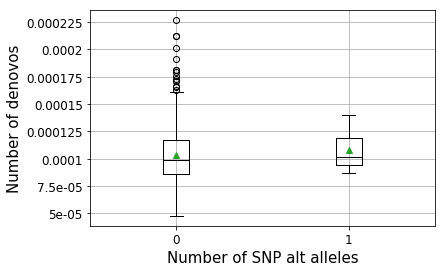

In [69]:
# Plot by HTT SNP status
pthresh = 0.8

htt = pd.read_csv("../other_data/ssc_htt_snp_status.tab", sep="\t", names=["sample","gt"])
htt2 = pd.read_csv("../other_data/ssc_htt_snp2_status.tab", sep="\t", names=["sample","gt"])
ped = pd.read_csv("../../metadata/ssc_family_ids.txt", sep="\t", names=["id","sample"])
sscpop = pd.read_csv("../../metadata/ssc_family_populations.tab", sep="\t")
sscpop = pd.merge(sscpop, bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"]==pthresh)],
                  on=["family"])

ped["family"] = ped["id"].apply(lambda x: int(x.split(".")[0]))
ped["rel"] = ped["id"].apply(lambda x: x.split(".")[1])
htt = pd.merge(htt, ped, on=["sample"])
htt = htt[(htt["rel"]=="mo") | (htt["rel"]=="fa")]
htt = pd.merge(htt, sscpop, on=["family"])
htt = htt[htt["Superpop"]!="AFR"]
htt2 = pd.merge(htt2, ped, on=["sample"])
htt2 = htt2[(htt2["rel"]=="mo") | (htt2["rel"]=="fa")]
htt2 = pd.merge(htt2, sscpop, on=["family"])
htt2 = htt2[htt2["Superpop"]!="AFR"]

def AggGT(x):
    total = 0
    for item in x:
        alleles = sum([int(a) for a in item.split("|")])
        total += alleles
    return total
httfam = htt.groupby("family", as_index=False).agg({"gt":AggGT,"rate": np.mean})
httfam2 = htt2.groupby("family", as_index=False).agg({"gt":AggGT,"rate": np.mean})
httfam = httfam2
#httfam = pd.merge(httfam, httfam2,on=["family","rate"])
#httfam["gt"] = httfam["gt_x"]+httfam["gt_y"]

fig = plt.figure()
ax = fig.add_subplot(111)
boxprops = dict(linestyle='-', linewidth=1)
medianprops = dict(linestyle='-', linewidth=1)

bp = httfam.boxplot(by="gt", column="rate", ax=ax, boxprops=boxprops,
                medianprops=medianprops, return_type='dict', showmeans=True);
[[item.set_color("black") for item in bp[key]['boxes']] for key in bp.keys()]
[[item.set_color("black") for item in bp[key]['medians']] for key in bp.keys()]
[[item.set_color("black") for item in bp[key]['whiskers']] for key in bp.keys()]

ax.set_title("");
fig.suptitle("")
ax.set_xlabel("");
ax.set_ylabel("Number of denovos", size=15)
ax.set_xlabel("Number of SNP alt alleles", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

scipy.stats.ks_2samp(httfam[httfam["gt"]==max(httfam["gt"])]["rate"],
                     httfam[httfam["gt"]<max(httfam["gt"])]["rate"])

In [48]:
# Posterior analysis
families = [] 
expected_u = []
expected_a = []
observed_u = []
observed_a = []
pthresh = []

bychild["prior_sum_scaled"] = bychild["prior_sum"]*2.45 # using scale factor from CODIS TODO

for f in (set(bychild["family"])):
    exp_u = bychild[(bychild["family"] == f) & (bychild["status"]==1) & (bychild["pthresh"]==0)]["prior_sum_scaled"].values[0]
    exp_a = bychild[(bychild["family"] == f) & (bychild["status"]==2) & (bychild["pthresh"]==0)]["prior_sum_scaled"].values[0]
    for p in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]:
        obs_u = bychild[(bychild["family"] == f) & (bychild["status"]==1) & (bychild["pthresh"]==p)]["numutations"].values[0]
        obs_a = bychild[(bychild["family"] == f) & (bychild["status"]==2) & (bychild["pthresh"]==p)]["numutations"].values[0]
        expected_u.append(exp_u)
        expected_a.append(exp_a)
        observed_u.append(obs_u)
        observed_a.append(obs_a)
        pthresh.append(p)
        families.append(f)

pdata = pd.DataFrame({
    "family": families,
    "exp_u": expected_u,
    "exp_a": expected_a,
    "obs_u": observed_u,
    "obs_a": observed_a,
    "pthresh": pthresh
})
pdata["diff_a"] = pdata["obs_a"]-pdata["exp_a"]
pdata["diff_u"] = pdata["obs_u"]-pdata["exp_u"]
pdata = pdata[["family","exp_u","exp_a","obs_u","obs_a","pthresh","diff_a","diff_u"]]

0.636575218576
Ttest_indResult(statistic=0.71798215193487758, pvalue=0.47294518585799683)
Ks_2sampResult(statistic=0.065263157894736856, pvalue=0.25522163916107449)


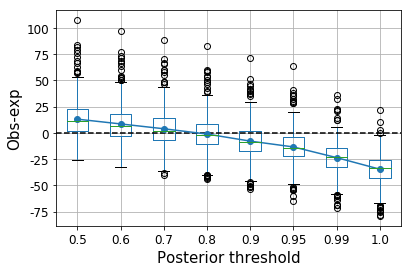

In [70]:
# Plot diff vs. posterior threshold
fig = plt.figure()
ax = fig.add_subplot(111)
bp = pdata.boxplot(by="pthresh", column="diff_u", ax=ax, return_type="dict")
ax.set_title("");
fig.suptitle("")
ax.set_xlabel("");
ax.set_ylabel("Obs-exp", size=15)
ax.set_xlabel("Posterior threshold", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);

ax.axhline(y=0, linestyle="dashed", color="black")

# Plot means
pdata_means = pdata.groupby("pthresh", as_index=False).agg({"diff_u": np.mean})
ax.plot(ax.get_xticks(), pdata_means["diff_u"], marker="o");

# Compare children
print(np.mean(pdata[pdata["pthresh"]==1].apply(lambda x: x["diff_a"]-x["diff_u"], 1)))
print(str(scipy.stats.ttest_ind(pdata[pdata["pthresh"]==1]["diff_a"],
                      pdata[pdata["pthresh"]==1]["diff_u"])))
print(str(scipy.stats.ks_2samp(pdata[pdata["pthresh"]==1]["diff_a"],
                    pdata[pdata["pthresh"]==1]["diff_u"])))

# Scratch